# Chapter 3 - Linear Regression

- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

In [1]:
using BenchmarkTools
using DataFrames
using DelimitedFiles
using CSV
using Plots
using GLM

### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [2]:
advertising = CSV.read("Data/Advertising.csv", DataFrame, select=[2,3,4,5])
describe(advertising)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,TV,147.043,0.7,149.75,296.4,0,Float64
2,Radio,23.264,0.0,22.9,49.6,0,Float64
3,Newspaper,30.554,0.3,25.75,114.0,0,Float64
4,Sales,14.0225,1.6,12.9,27.0,0,Float64


In [3]:
credit = CSV.read("Data/Credit.csv", DataFrame, select=collect(2:13))
function f(x)
    x = (x == "Yes" ? 1 : 0);
end
credit.Student2 = f.(credit.Student)
first(credit, 3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity
,Float64,Int64,Int64,Int64,Int64,Int64,String7,String3,String3,String31
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian
3,104.593,7075,514,4,71,11,Male,No,No,Asian


In [4]:
auto = dropmissing(CSV.read("Data/Auto.csv", DataFrame, missingstring="?"))
describe(auto)

,variable,mean,min,median,max,nmissing
,Symbol,Union…,Any,Union…,Any,Int64
1,mpg,23.4459,9.0,22.75,46.6,0
2,cylinders,5.47194,3,4.0,8,0
3,displacement,194.412,68.0,151.0,455.0,0
4,horsepower,104.469,46,93.5,230,0
5,weight,2977.58,1613,2803.5,5140,0
6,acceleration,15.5413,8.0,15.5,24.8,0
7,year,75.9796,70,76.0,82,0
8,origin,1.57653,1,1.0,3,0
9,name,,amc ambassador brougham,,vw rabbit custom,0


## 3.1 Simple Linear Regression

### Figure 3.1 - Least Squares Fit

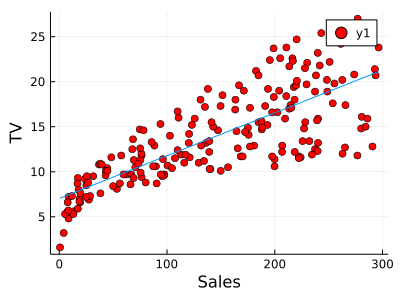

In [5]:
scatter(advertising.TV, advertising.Sales, markercolor=:red, smooth=true, size=(400,300))
xlabel!("Sales")
ylabel!("TV")

### Figure 3.2 - Regression coefficients - RSS
The Data has been centered before calculating the coefficients.
We use the GLM package for fitting. 
More info: https://juliastats.org/GLM.jl/latest/examples/

In [6]:
# Regression coefficients (Ordinary Least Squares)
advertising.TV = advertising.TV .- mean(advertising.TV)
ols = lm(@formula(Sales ~ TV), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Sales ~ 1 + TV

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  14.0225     0.230422    60.86    <1e-99  13.5681     14.4769
TV            0.0475366  0.00269061  17.67    <1e-41   0.0422307   0.0528426
────────────────────────────────────────────────────────────────────────────

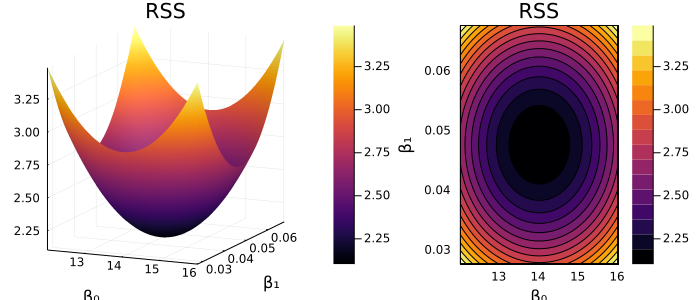

In [7]:
X = advertising.TV
Y = advertising.Sales

B0 = collect(range(coef(ols)[1] -2, coef(ols)[1] + 2 ; length=50))
B1 = collect(range(coef(ols)[2] -0.02, coef(ols)[2] + 0.02 ; length=50))

function RSS(x,y)
    sum((Y .- x .- X.*y).^2)/1000
end
Z = RSS.(B0,B1')

l = @layout [a{0.6w} b]
p1 = plot(B0 , B1 , Z , st = :surface)
p2 = plot(B0 , B1 , Z , st = :contourf, legend=true)
p = plot(p1,p2, layout=l, size=(700,300))
xlabel!("β₀")
ylabel!("β₁")
title!("RSS")

### Confidence interval on Page 67 and Table 3.1 & 3.2

In [8]:
advertising = CSV.read("Data/Advertising.csv", DataFrame, select=[2,3,4,5])
ols = lm(@formula(Sales ~ TV), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Sales ~ 1 + TV

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  7.03259    0.457843    15.36    <1e-34  6.12972    7.93547
TV           0.0475366  0.00269061  17.67    <1e-41  0.0422307  0.0528426
─────────────────────────────────────────────────────────────────────────

In [9]:
# RSS with regression coefficients
sum((advertising.Sales .- coef(ols)[1] .- advertising.TV.*coef(ols)[2]).^2)/1000

2.102530583131351

In [10]:
#Also can be calculated in the following manner
println("RSS: ",deviance(ols)/1000)

RSS: 2.1025305831313514


In [11]:
#R2 Score of the regression
println("R² Score: ", r2(ols))

R² Score: 0.611875050850071


## 3.2 Multiple Linear Regression

In [12]:
est = lm(@formula(Sales ~ Radio), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Sales ~ 1 + Radio

Coefficients:
────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────
(Intercept)  9.31164    0.5629     16.54    <1e-38   8.20159   10.4217
Radio        0.202496   0.0204113   9.92    <1e-18   0.162244   0.242747
────────────────────────────────────────────────────────────────────────

In [13]:
est = lm(@formula(Sales ~ Newspaper), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Sales ~ 1 + Newspaper

Coefficients:
────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  12.3514      0.62142    19.88    <1e-48  11.126      13.5769
Newspaper     0.0546931   0.0165757   3.30    0.0011   0.0220055   0.0873807
────────────────────────────────────────────────────────────────────────────

In [14]:
est = lm(@formula(Sales ~ TV + Radio + Newspaper), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Sales ~ 1 + TV + Radio + Newspaper

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)   2.93889     0.311908     9.42    <1e-16   2.32376    3.55402
TV            0.0457646   0.0013949   32.81    <1e-80   0.0430137  0.0485156
Radio         0.18853     0.00861123  21.89    <1e-53   0.171547   0.205513
Newspaper    -0.00103749  0.00587101  -0.18    0.8599  -0.012616   0.010541
────────────────────────────────────────────────────────────────────────────

### Table 3.5 Correlation Matrix

In [15]:
using Statistics
df = advertising
DataFrame(cor(Matrix(advertising)), names(df))

,TV,Radio,Newspaper,Sales
,Float64,Float64,Float64,Float64
1,1.0,0.0548087,0.0566479,0.782224
2,0.0548087,1.0,0.354104,0.576223
3,0.0566479,0.354104,1.0,0.228299
4,0.782224,0.576223,0.228299,1.0


### Figure 3.5 - Multiple Linear Regression

In [16]:
est = lm(@formula(Sales ~ TV + Radio), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Sales ~ 1 + TV + Radio

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  2.9211     0.29449      9.92    <1e-18  2.34034    3.50186
TV           0.0457548  0.00139036  32.91    <1e-81  0.0430129  0.0484967
Radio        0.187994   0.00803997  23.38    <1e-58  0.172139   0.20385
─────────────────────────────────────────────────────────────────────────

┌ Info: Saved animation to 
│   fn = C:\Users\Heril\ISLR-Julia\Notebooks\tmp.gif
└ @ Plots C:\Users\Heril\.julia\packages\Plots\1KWPG\src\animation.jl:114


Plots.AnimatedGif("C:\\Users\\Heril\\ISLR-Julia\\Notebooks\\tmp.gif")
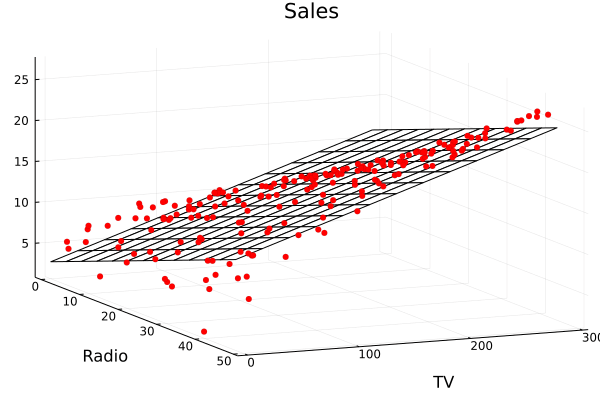

In [17]:
# Create the Plot
Radio = collect(range(0,49;step=4))
TV = collect(range(0,299;step=24))

function pl(x,y)
    coef(est)[1] + x*coef(est)[3] + y*coef(est)[2]
end
Z = pl.(Radio, TV')
@gif for i in range(0, stop = 2π, length = 50)
    plot(Radio, TV, pl,st=:wireframe, camera=(30 * (1 + cos(i)), 40))
    scatter3d!(advertising.Radio, advertising.TV, advertising.Sales, markercolor=:red, markerstrokewidth=0, legend=false)
    xlabel!("Radio")
    ylabel!("TV")
    title!("Sales")
end

## 3.3 Other Considerations in the Regression Model


### Figure 3.6
pairwise Scatterplots can be implemented by `cornerplot()` in `StatsPlot`. But it can be easily implemented using `Plots` module itself.  

In [18]:
using Measures
#using Statsplots
#cornerplot(Matrix(df))

function pairplot(df::DataFrame)
    pyplot()
    mat = Matrix(df)
    cols = names(df)
    n = length(cols)
    pall = [plot(mat[:,i],mat[:,j], st= (i==j ? :hist : :scatter), smooth= (i==j ? false : true), markercolor=:skyblue, linecolor=:blue3, linewidth=(i==j ? 0.1 : 1), markeralpha=0.7, markersize=2, legend=false, xlabel=cols[i], ylabel=cols[j], guidefontsize=5) for i=1:n, j=1:n]
    plot(pall..., layout=(n,n), markerstrokewidth=0, showaxis=false, tickfontsize=0, margin= 0mm, size=(800,800))
end

df = credit[:,[:Balance, :Age, :Cards, :Education, :Income, :Limit, :Rating]];
pairplot(df)

LoadError: ArgumentError: Package Measures not found in current path:
- Run `import Pkg; Pkg.add("Measures")` to install the Measures package.


### Table 3.7

In [19]:
est = lm(@formula(Balance ~ Gender), credit)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Balance ~ 1 + Gender

Coefficients:
───────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)     509.803      33.1281  15.39    <1e-41   444.675     574.931
Gender: Female   19.7331     46.0512   0.43    0.6685   -70.8009    110.267
───────────────────────────────────────────────────────────────────────────

### Table 3.8


In [20]:
est = lm(@formula(Balance ~ Ethnicity), credit)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Balance ~ 1 + Ethnicity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                         Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)           531.0        46.3187  11.46    <1e-25    439.939    622.061
Ethnicity: Asian      -18.6863     65.0211  -0.29    0.7740   -146.515    109.142
Ethnicity: Caucasian  -12.5025     56.681   -0.22    0.8255   -123.935     98.93
─────────────────────────────────────────────────────────────────────────────────

### Table 3.9 - Interaction Variables

In [21]:
est = lm(@formula(Sales ~ TV + Radio + TV*Radio), advertising)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Sales ~ 1 + TV + Radio + TV & Radio

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.  Std. Error      t  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  6.75022     0.247871    27.23    <1e-67  6.26138      7.23906
TV           0.0191011   0.00150415  12.70    <1e-26  0.0161347    0.0220675
Radio        0.0288603   0.00890527   3.24    0.0014  0.0112979    0.0464228
TV & Radio   0.00108649  5.24204e-5  20.73    <1e-50  0.000983114  0.00118988
─────────────────────────────────────────────────────────────────────────────

### Figure 3.7 - Interaction between qualitative and quantitative variables

In [22]:
## Regression 1 - without interaction terms
est1 = lm(@formula(Balance ~ Income + Student2), credit)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Balance ~ 1 + Income + Student2

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  211.143     32.4572     6.51    <1e-09  147.333    274.952
Income         5.98434    0.556623  10.75    <1e-23    4.89004    7.07863
Student2     382.671     65.3108     5.86    <1e-08  254.272    511.069
─────────────────────────────────────────────────────────────────────────

In [23]:
## Regression 1 - without interaction terms
est2 = lm(@formula(Balance ~ Income + Student2 + Income*Student2), credit)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Balance ~ 1 + Income + Student2 + Income & Student2

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                       Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)        200.623     33.6984     5.95    <1e-08  134.373    266.873
Income               6.21817    0.592094  10.50    <1e-22    5.05413    7.38221
Student2           476.676    104.351      4.57    <1e-05  271.524    681.827
Income & Student2   -1.99915    1.73125   -1.15    0.2489   -5.40274    1.40444
───────────────────────────────────────────────────────────────────────────────

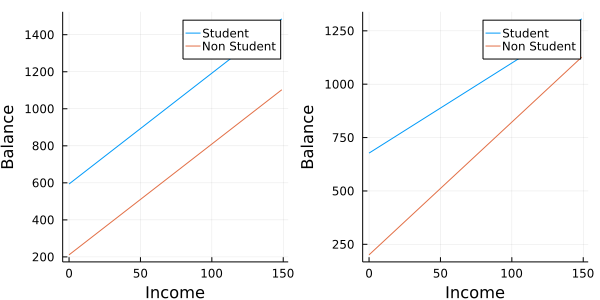

In [24]:
#Income (x-axis)
income = collect(range(0,149;step=1))

# Balance without interaction term (y-axis)
student1     = coef(est1)[1] .+ coef(est1)[2].*income .+ coef(est1)[3]
non_student1 = coef(est1)[1] .+ coef(est1)[2].*income

# Balance with interaction term (y-axis)
student2     = coef(est2)[1] .+ coef(est2)[2].*income .+ coef(est2)[3] .+ coef(est2)[4].*income
non_student2 = coef(est2)[1] .+ coef(est2)[2].*income

p1 = plot(income, student1, st=:line, label="Student", size=(600,300))
plot!(p1, income, non_student1, st=:line, label="Non Student");

p2 = plot(income, student2, st=:line, label="Student", size=(600,300))
plot!(p2, income, non_student2, st=:line, label="Non Student");

plot(p1, p2, layout=2, xlabel="Income", ylabel="Balance")


### Figure 3.8 - Non-linear relationships

In [25]:
using Polynomials
linearpred = Polynomials.fit(auto.horsepower, auto.mpg , 1).(auto.horsepower);
quadpred = Polynomials.fit(auto.horsepower, auto.mpg , 2).(auto.horsepower);
pentapred = Polynomials.fit(auto.horsepower, auto.mpg , 5).(auto.horsepower);
scatter(auto.horsepower, auto.mpg, markerstrokewidth=0, markersize=5, label="mpg")
plot!(auto.horsepower, linearpred, st=:line, linecolor= :orange, label="Linear", linewidth=2)
plot!(auto.horsepower, quadpred, st=:line, linecolor= :teal, label="Degree 2", linewidth=2)
plot!(auto.horsepower, pentapred, st=:line, linecolor= :green, label="Degree 5", linewidth=2)
xlabel!("horsepower")
ylabel!("mpg")

LoadError: ArgumentError: Package Polynomials not found in current path:
- Run `import Pkg; Pkg.add("Polynomials")` to install the Polynomials package.


### Table 3.10

In [26]:
auto.horsepower2 = auto.horsepower.^2;
first(auto,3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
,Float64,Int64,Float64,Int64,Int64,Float64,Int64,Int64
1,18.0,8,307.0,130,3504,12.0,70,1
2,15.0,8,350.0,165,3693,11.5,70,1
3,18.0,8,318.0,150,3436,11.0,70,1


In [27]:
linfit  = lm(@formula(mpg ~ horsepower), auto);
quadfit = lm(@formula(mpg ~ horsepower + horsepower2), auto)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

mpg ~ 1 + horsepower + horsepower2

Coefficients:
──────────────────────────────────────────────────────────────────────────────────
                   Coef.   Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────
(Intercept)  56.9001      1.80043       31.60    <1e-99  53.3603       60.4399
horsepower   -0.46619     0.0311246    -14.98    <1e-39  -0.527383     -0.404996
horsepower2   0.00123054  0.000122076   10.08    <1e-20   0.000990525   0.00147055
──────────────────────────────────────────────────────────────────────────────────

### Figure 3.9

In [28]:
#Residuals for the Linear Fit
pred1  = predict(linfit)
resid1 = auto.mpg .- pred1

#residuals for the Quadratic Fit
pred2 = predict(quadfit)
resid2 = auto.mpg .- pred1;

In [29]:
scatter(pred1, resid1, markerstrokewidth=0, title="Residual Plot for Linear Fit")
smoothfit = Polynomials.fit(pred1, resid1, 3).(pred1)
plot!(pred1 ,smoothfit, linecolor=:red, st=:line, legend=false)
xlabel!("Residuals")
ylabel!("Fitted Values")
#At the time of writing, I couldnot find well documented Lowess plot

LoadError: UndefVarError: Polynomials not defined

In [30]:
scatter(pred2, resid2, markerstrokewidth=0, title="Residual Plot for Quadratic Fit")
smoothfitquad = Polynomials.fit(pred2, resid2, 3).(pred2)
plot!(pred2 ,smoothfitquad, linecolor=:red, st=:line, legend=false)
xlabel!("Residuals")
ylabel!("Fitted Values")
#At the time of writing, I couldnot find well documented Lowess plot

LoadError: UndefVarError: Polynomials not defined

### Figure 3.14

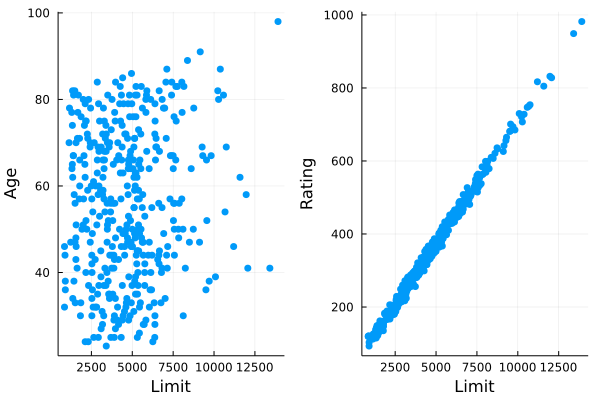

In [31]:
p1 = scatter(credit.Limit, credit.Age, markerstrokewidth=0, ylabel="Age")
p2 = scatter(credit.Limit, credit.Rating, markerstrokewidth=0, ylabel="Rating")
plot(p1, p2, layout=(2), xlabel="Limit", legend=false)

### Figure 3.15

In [32]:
#Scaling the variables with mean
credit.Age = credit.Age .- mean(credit.Age)
credit.Limit = credit.Limit .- mean(credit.Limit)

linfit1 = lm(@formula(Balance ~ Age + Limit), credit)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Balance ~ 1 + Age + Limit

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                  Coef.   Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  520.015     11.5266      45.11    <1e-99  497.354     542.676
Age           -2.29149    0.672485    -3.41    0.0007   -3.61356    -0.96941
Limit          0.173365   0.00502566  34.50    <1e-99    0.163485    0.183245
─────────────────────────────────────────────────────────────────────────────

In [33]:
#Scaling the variables with mean
credit.Rating = credit.Rating .- mean(credit.Rating)
credit.Limit = credit.Limit .- mean(credit.Limit)

linfit2 = lm(@formula(Balance ~ Rating + Limit), credit)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

Balance ~ 1 + Rating + Limit

Coefficients:
────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────
(Intercept)  520.015      11.616      44.77    <1e-99  497.178     542.852
Rating         2.20167     0.952294    2.31    0.0213    0.329503    4.07384
Limit          0.0245144   0.0638346   0.38    0.7012   -0.100982    0.15001
────────────────────────────────────────────────────────────────────────────

In [34]:
B_Age   = collect(range(coef(linfit1)[2] -3, coef(linfit1)[2] + 3 ; length=100))
B_Limit = collect(range(coef(linfit1)[3] -0.02, coef(linfit1)[3] + 0.02 ; length=100))

B_Rating = collect(range(coef(linfit2)[2] -3, coef(linfit2)[2] + 3 ; length=100))
B_Limit2 = collect(range(coef(linfit2)[3] -0.2, coef(linfit2)[3] + 0.2 ; length=100))

function RSS_1(x, y)
    ols = linfit1
    Y = credit.Balance
    sum((Y .- coef(ols)[1] .- x.*credit.Age .- y.*credit.Limit).^2)/1000000
end
function RSS_2(x, y)
    ols = linfit2
    Y = credit.Balance
    sum((Y .- coef(ols)[1] .- x.*credit.Rating .- y.*credit.Limit).^2)/1000000
end
Z1 = RSS_1.(B_Age, B_Limit');
Z2 = RSS_2.(B_Rating, B_Limit2');

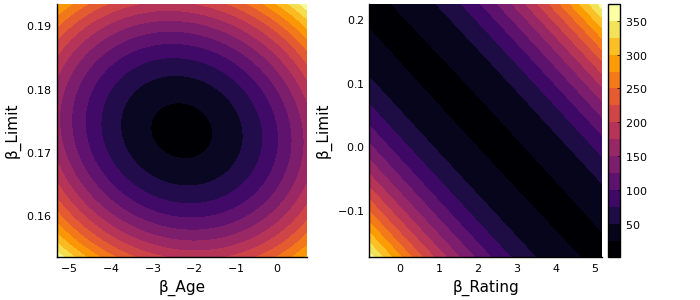

sys:1: UserWarning: The following kwargs were not used by contour: 'label'


In [35]:
pyplot()
p1 = plot(B_Age, B_Limit , Z1 , st = :contourf, legend=false, xlabel="β_Age")
p2 = plot(B_Rating, B_Limit2 , Z2 , st = :contourf, xlabel="β_Rating")
plot(p1, p2, ylabel="β_Limit", layout=(2), size=(700,300))

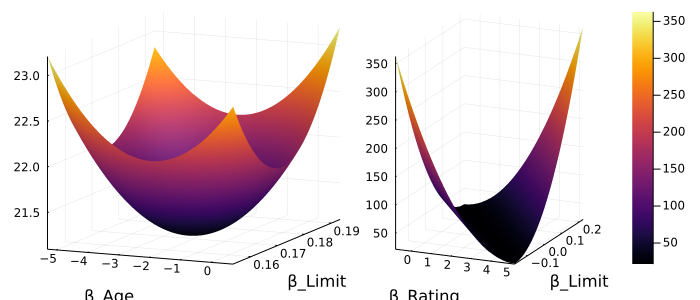

In [36]:
gr()
p1 = plot(B_Age, B_Limit , Z1 , st = :surface, legend=false, xlabel="β_Age")
p2 = plot(B_Rating, B_Limit2 , Z2 , st = :surface, xlabel="β_Rating")
plot(p1, p2, ylabel="β_Limit", layout=(2), size=(700,300))